In [4]:
import numpy.random
import matplotlib.pyplot as plt

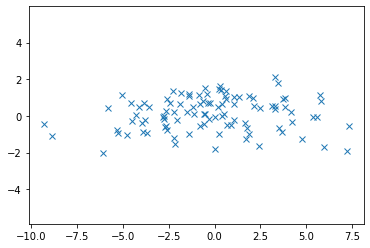

In [5]:
mean = [0, 0]
cov = [[9, 0], [0, 1]]

x, y = numpy.random.multivariate_normal(mean, cov, 100).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

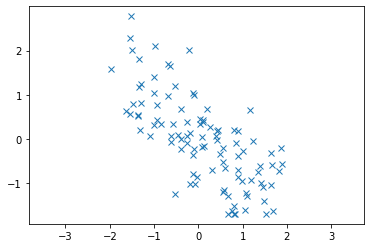

In [6]:
mean = [0, 0]
cov = [[1, -.75], [-.75, 1]]

x, y = numpy.random.multivariate_normal(mean, cov, 100).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [92]:
import torch
import numpy as np
from torch.distributions import normal
from torch.distributions import multivariate_normal


''' Read data from txt as tensors'''
def readData(trainFile, testFile, valFile):
    
    # read training data
    train_data = np.loadtxt(trainFile)
    train_vec = train_data[:,:-1]
    train_lab = train_data[:,-1]
    
    # read testing data
    test_data = np.loadtxt(testFile)
    test_vec = test_data[:,:-1]
    test_lab = test_data[:,-1]
    
    # read validation data
    val_data = np.loadtxt(valFile)
    val_vec = val_data[:,:-1]
    val_lab = val_data[:,-1]
    
    return torch.tensor(train_vec), torch.tensor(train_lab), torch.tensor(test_vec), torch.tensor(test_lab), \
        torch.tensor(val_vec), torch.tensor(val_lab)

# feature extractors
'''
    Feature extractor 0 --- only for univariate gaussian
    input: vectors of extended image (None, 784)
    output: sum of all pixel values for each image (None, 1)
    '''
def fe0(X):
    return torch.sum(X,dim=1)

'''
    Feature extractor 1 --- only for multivariate gaussian
    input: vectors of extended image (None, 784)
    output: number of nonzero pixels on each row & each column.  (None, 56)
    Remember that the input image is of size 28*28
'''
def fe1(X):
    X_row = torch.where(X>0,torch.ones_like(X),torch.zeros_like(X)).reshape(-1,28,28)\
    .sum(dim=1)
    X_col = torch.where(X>0,torch.ones_like(X),torch.zeros_like(X)).reshape(-1,28,28)\
    .sum(dim=2)
    return torch.cat([X_row,X_col],dim=1)

'''
    Feature extractor 2 --- only for multivariate gaussian
    input: vectors of extended image (None, 784)
    output: input                    (None, 784)
'''
def fe2(X):
    return X    # this function does nothing :( but you can build your own features if you like! :)

fe = [fe0,fe1,fe2]

# do not change these
prior = None       # list of the priors. Made from empirical counts
dists = None       # list of Gaussian distributions likelihood. size = number of classes
num_c = 0          # number of classes
ID_FE = 0          # select feature extractor

'''
    Train your model
    input: X - training data
           y - training labels
           uni - set as True for univariate model
'''
def train(X,y,uni=True):
    global ID_FE
    if uni:
        ID_FE=0
    else:
        ID_FE=1
    global dists; dists = list()
    uniq_y = torch.unique(y)                           # get all labels
    global num_c; num_c = uniq_y.shape[0]              # number of classes
    global prior; prior = torch.zeros(uniq_y.shape) # initialize prior P(Y) to zeros
    for idx in range(num_c):           # for each label
        mask = torch.eq(y,idx)
        x_by_label = X[mask]           # select all observations with label
        
        prior[idx] = len(x_by_label) / len(X)              ##### TODO : Estimate your model's prior P(Y) (parts a, b, and c)
        
        x = fe[ID_FE](x_by_label)      # extract the feature vector
        
        if uni: ##### Univariate gaussian (parts a and b)
            
            ########### TODO: Estimate the univariate Gaussian conditional distributions (parts a and b)           
            ##### Hint: Compute the empirical mean and variance. Then you can call PyTorch's "Normal" 
            #####       function with the correct arguments to build the distribution. We have already 
            #####       imported the relevant function for you. You can refer to PyTorch's official       
            #####       documentation for more info. 
            x_mean = torch.mean(x)                ##### TODO : calculate the mean value 
            x_var =  torch.from_numpy(np.cov(x))                  ##### TODO : calculate the variance
            print(idx, ":\tprior:" , prior[idx].numpy(), "\tvar:" , torch.var(x).item(), "\tmean:", x_mean.item())
            gaussian_dist = torch.distributions.normal.Normal(x_mean, x_var**.5)          ##### TODO : replace 'None' with distribution's constructor
            
        else: ##### Multivariate Gaussian. (part c)
            
            ########### TODO: Estimate the multivariate Gaussian conditional distributions (part c)           
            ##### Hint: In this part, you will call PyTorch's "MultivariateNormal" function to biuld    
            #####       a multivariate normal distribution. The function is already imported.     
            x_mean= torch.mean(x,0)                  ##### TODO : estimate the mean vector
            x_cov = torch.from_numpy(np.cov(x.T)) + (1.28*torch.eye(len(x_mean), dtype=torch.float64))                   ##### TODO : estimate the covariance matrix
            gaussian_dist = torch.distributions.multivariate_normal.MultivariateNormal(x_mean, x_cov)          ##### TODO : replace 'None' with distribution's constructor
            
        dists.append(gaussian_dist)
    return

'''
    Use Bayes rule to predict on one sample
'''
def predict(x):
    x = fe[ID_FE](torch.reshape(x,(1,-1)))
    result = [dists[i].log_prob(x)*prior[i] for i in range(num_c)]
    return torch.argmax(torch.tensor(result))

'''
    Evaluate classification accuracy
'''
def evaluate(X,y):
    correct = 0
    for i in range(X.shape[0]):
        if predict(X[i]) == y[i].long():
            correct = correct + 1
    print('The classification accuracy is {}'.format(correct/X.shape[0]))
    return


if __name__ == "__main__":
    
    # TODO: Replace with  correct paths to the data files (parts a, b, and c)
    train_vec, train_lab, test_vec, test_lab, val_vec, val_lab = readData('hw0train.txt','hw0test.txt','hw0validate.txt')   

#    train(train_vec,train_lab,True)   # (parts a and b) Call univariate train function to estimate your model's parameters from the training data
    train(train_vec,train_lab,False)  # (part c) Call multivariate train function to estimate your model's parameters from the training data

    evaluate(train_vec, train_lab)    # Call evaluate function to compute classification error on the training data.
    evaluate(val_vec, val_lab)        # Call evaluate function to compute classification error on the validation data.
    evaluate(test_vec, test_lab)      # Call evaluate function to compute classification error on the test data.


The classification accuracy is 0.92
The classification accuracy is 0.837
The classification accuracy is 0.824
